---
title: "Differential Equations II"
subtitle: ""
format: 
  html:
    toc: true
    code-fold: false
    page-layout: full
    fig-cap-location: bottom
    number-sections: true
    number-depth: 2
    html-to-math: katex
    html-math-method: katex
    callout-appearance: minimal
jupyter: python3
---

# Boundary-Value Problems
Our prototypical _boundary-value problem (BVP)_ will be a second-order ODE:
$$
w''(x) = f(x,w,w'),\quad w(a) = c, \quad w(b) = d.
$$
Since $w'(a)$ is not given, this is not an initial value problem. Here, the function value at the other end $w(b)$ is given. This is known as the _Dirichlet boundary condition_.
On the other hand, if $w'(b)$ is given instead, then we have the _Neumann boundary condition_.

Below, we will discuss two general approaches to solving this BVP: (a) treat it as a more complicated version of an initial-value problem, or (b) use the fact that we
know two boundary conditions and set up a method accordingly. We discuss these two approaches in turn.

## Shooting Method
In the BVP, we don't have the value $w'(a)$. But what if we simply guess the value $w'(a)$, and try to integrate it from $a$ to $b$? 

![Illustration of the shooting method for a boundary-value problem](week15_files/1.png){#fig-shooting}

Obviously, a random guess is extremely unlikely to be able to satisfy the boundary condition $w(b)$; that's OK, though, because we can try again. In the example of this figure, it's easy to see that the value for $w(a)$ we first chose was too small; we can simply adjust that to be larger and try again. The second
attempt doesn't satisfy the boundary condition $w(b)$ either; we can keep playing this game, though. This time, we reduce the value of $w(a)$ and try again. Eventually, this process will lead to a value of $w(a)$ that is "just right", allowing us to go through the point $w(b)$, as desired. (The figure shows the, highly optimistic, scenario where it only took us three tries to get there.) This iterative procedure is obviously analogous to aiming at a target and, as a result, is known as the shooting method.

Let us try to recast the above prescription in a more systematic way. Our input is $w(a) = c$ and $w(b) = d$. In the language of our discretization scheme(s), these input conditions can be expressed as $w_0 = c$ and $w_{n−1} = d$. What we do not know is $w'(a)$, but let's assume that its (unknown) value is $\sigma$, i.e. $w'(a)=\sigma$. You can take $c$ and $\sigma$, plug them into a numerical integrator like you learned in the previous lecture, and determine the corresponding $w_{n-1}$ value that comes out. In other words, a method like RK4 for this problem transforms the input guess $\sigma$ into a specific output at the right endpoint, $w_{n−1}$; mathematical we can say that our integration method is a function that takes us from $\sigma$ to $w_{n−1}$, i.e., $g(\sigma) = w_{n−1}$, where $g$ is a new function describing the effect of solving our ODE with a given $\sigma$, from $a$ to $b$. In this language, since our goal is that $w_{n−1} = d$, we can demand that:
$$
g(\sigma) = d. 
$$

To reiterate, $g$ is not an analytically known function (like $f$); instead, it is the result of carrying out a full initial-value problem solution from $a$ to $b$. Then, what we are faced is a root-finding problem. The function $g$ may be linear or nonlinear, but this is irrelevant, since we know already how to solve a general algebraic equation; as a matter of fact, $f$ itself may be linear or nonlinear, but this doesn't really change how the shooting method works. To summarize, the shooting method combines initial-value solvers like forward Euler with iterative solvers like Newton's method: for each guess of $\sigma$ an IVP needs to be solved. This confirms our earlier claim that boundary-value problems are more complicated to solve than initial-value problems.

### Implementation
A code implementing the shooting method will fuse two elements: a numerical integrator and a root-finder. As already mentioned, this is a general feature, regardless of whether or not the ODE we are faced with is linear. For the sake of concreteness, we will here tackle the Legendre differential equation (again) that, in its latest incarnation, was used to illustrate the solution of two simultaneous differential equations. This time around, instead of providing $w(a)$ and $w'(a)$ like before, our input will be $w(a)$ and $w(b)$:
$$
\begin{gather*}
w''(x) = -\frac{30}{1-x^2}w(x) + \frac{2x}{1-x^2}w'(x)\\
w(0.05) = 1,\quad w(0.49) = 1.2063.
\end{gather*}
$$

Note that we define a new function, `shoot()`, which plays the role $g(\sigma)-d$. `shoot()` takes an input of $w'(a)$, and returns `ws[-1,0] - wfinal`, where `ws[-1,0]` is actually $w(b)$ computed from the input $w'(a)$, and `wfinal` is the desired $w(b)$.  

We use the `secant()` function to find the root of `shoot()`. This would produce the solution to the BVP. 

In [3]:
import numpy as np

def shoot(sig):
    a, b, n = 0.05, 0.49, 100
    yinits = np.array([1., sig])
    xs, ws = rk4_gen(fs,a,b,n,yinits)  
    wfinal = 1.2063
    return ws[-1, 0] - wfinal

def fs(x,yvals):
    y0, y1 = yvals
    f0 = y1
    f1 = - (30/(1-x**2))*y0 + ((2*x)/(1-x**2))*y1 
    return np.array([f0, f1])

def rk4_gen(fs,a,b,n,yinits):
    h = (b-a)/(n-1)
    xs = a + np.arange(n)*h
    ys = np.zeros((n, yinits.size))

    yvals = np.copy(yinits)
    for j,x in enumerate(xs):
        ys[j,:] = yvals
        k0 = h*fs(x, yvals)
        k1 = h*fs(x+h/2, yvals+k0/2)
        k2 = h*fs(x+h/2, yvals+k1/2)
        k3 = h*fs(x+h, yvals+k2)
        yvals += (k0 + 2*k1 + 2*k2 + k3)/6
    return xs, ys

def secant(f,x0,x1,kmax=200,tol=1.e-8):
    f0 = f(x0)
    for k in range(1,kmax):
        f1 = f(x1)
        ratio = (x1 - x0)/(f1 - f0)
        x2 = x1 - f1*ratio

        xdiff = abs(x2-x1)
        x0, x1 = x1, x2
        f0 = f1

        # rowf = "{0:2d} {1:1.16f} {2:1.16f} {3:1.16f}"
        # print(rowf.format(k,x2,xdiff,abs(f(x2))))

        if abs(xdiff/x2) < tol:
            break
    else:
        x2 = None

    return x2

if __name__ == '__main__':
    wder = secant(shoot,0.,1.) 
    # return the w'(a) that leads to the desired w(b).
    print(wder)

19.530332700481605


##  Matrix Approach
The previous shooting method combines an IVP solver and a root-finder. We now turn to an alternative approach, which tackles our second-order ODE directly.

To be explicit, we first repeat our problem 
$$
w'' = f(x,w,w'), \quad w(a) = c, \quad w(b) = d.
$$
We now reach for the central-difference approximation to the first and second derivatives, for points on a grid. Then the above problem becomes
$$
\begin{gather*}
\frac{w_{j-1} - 2w_j + w_{j+1}}{h^2} = f\left(x_j, w_j, \frac{w_{j+1}-w_{j-1}}{2h}\right), \quad j = 1,2,\dots, n-2 \\
c_0 = c, \quad w_{n-1} = d
\end{gather*}
$$

Note that this set of equations involves only the $w_j$, i.e., there are no derivatives left. Posing and solving these equations is a process that is completely different from what we were doing for IVPs above: we _cannot_ start at the left endpoint and work our way to the right one; instead, we need to solve for _all_ of these $w_j$ values at the same time. Another way of putting the same fact: $w_{j-1}$, $w_j$ and $w_{j+1}$ appear on both the left-hand side and the right-hand side.

The approach is known as the _finite-difference_ method in literature. In order to avoid any confusion, and so as to emphasize its difference from the shooting method, we here keep things general and call it the _matrix approach_ to BVPs.

Observe that we haven't said much about $f$ so far: if this is linear (as in our example below), then we get linear system of equations (with a single solution). We have learned how to solve this type of problems.

If, on the other hand, $f$ is nonlinear, then we would be faced with a system of nonlinear equations which is a difficult problem.

### Matrix Method Applied to Our Equation
Let us consider our concrete problem
$$
f(x,w,w') = -\frac{30}{1-x^2}w(x) + \frac{2x}{1-x^2}w'(x).
$$
Using the matrix approach, we have
$$
w_{j-1}-2w_j+w_{j+1} = -h^2\frac{30}{1-x_j^2} w_j + \frac{h x_j}{1-x_j^2}(w_{j+1} - w_{j-1}), \quad j = 1,2,\dots, n-2,
$$
with boundary conditions $w_0 = 1$, $w_1 = 1.2063$.

If we group terms appropriately, we can re-express this problem as:
$$
\begin{gather*}
w_0 = 1, \\
\alpha_j w_{j-1} + \beta_j w_j + \gamma_j w_{j+1} = 0,\quad j = 1,2,\dots, n-2\\
w_{n-1} = 1.2063
\end{gather*}
$$
where we've defined 
$$
\alpha_j = 1 + \frac{hx_j}{1-x_j^2},\quad \beta_j = -2 + \frac{30 h^2}{1-x_j^2}, \quad \gamma_j = 1 - \frac{hx_j}{1-x_j^2}.
$$
Now, we have the matrix  equation
$$
\left(\begin{array}{ccccccc}
1 & 0 & 0 & \dots & 0 & 0 & 0\\
\alpha_{1} & \beta_{1} & \gamma_{1} & \dots & 0 & 0 & 0\\
0 & \alpha_{2} & \beta_{2} & \dots & 0 & 0 & 0\\
\vdots & \vdots & \vdots & \ddots & \vdots & \vdots & \vdots\\
0 & 0 & 0 & \dots & \beta_{n-3} & \gamma_{n-3} & 0\\
0 & 0 & 0 & \dots & \alpha_{n-2} & \beta_{n-2} & \gamma_{n-2}\\
0 & 0 & 0 & \dots & 0 & 0 & 1
\end{array}\right)\left(\begin{array}{c}
w_{0}\\
w_{1}\\
w_{2}\\
\vdots\\
w_{n-3}\\
w_{n-2}\\
w_{n-1}
\end{array}\right)=\left(\begin{array}{c}
1\\
0\\
0\\
0\\
0\\
0\\
1.2063
\end{array}\right),
$$
which is of the form $\boldsymbol{A}\boldsymbol{x}= \boldsymbol{b}$. The $n$ quantities $w_j$ are unknown and everything else in this equation is already known. 

### Implementation
The finite difference, or matrix-approach method is implemented in the following.

[1.         1.02152014 1.04300535 1.06445488 1.08586799 1.10724395
 1.12858201 1.14988143 1.17114148 1.19236143 1.21354052 1.23467804
 1.25577325 1.2768254  1.29783378 1.31879765 1.33971628 1.36058895
 1.38141491 1.40219345 1.42292384 1.44360536 1.46423728 1.48481888
 1.50534943 1.52582822 1.54625453 1.56662764 1.58694684 1.60721139
 1.62742061 1.64757376 1.66767013 1.68770903 1.70768973 1.72761153
 1.74747372 1.7672756  1.78701646 1.8066956  1.82631232 1.84586591
 1.86535569 1.88478095 1.904141   1.92343513 1.94266267 1.96182292
 1.98091518 1.99993878 2.01889302 2.03777722 2.0565907  2.07533277
 2.09400275 2.11259997 2.13112375 2.14957341 2.16794828 2.18624768
 2.20447095 2.22261743 2.24068643 2.2586773  2.27658938 2.29442199
 2.3121745  2.32984622 2.34743652 2.36494473 2.38237021 2.3997123
 2.41697035 2.43414372 2.45123177 2.46823385 2.48514932 2.50197755
 2.51871789 2.53536972 2.55193239 2.56840529 2.58478777 2.60107923
 2.61727902 2.63338654 2.64940115 2.66532225 2.68114922 2.69688

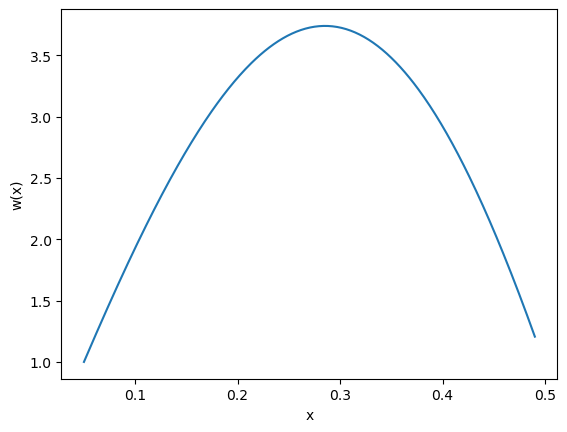

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def matsetup(a,b,n):
    h = (b-a)/(n-1)
    xs = a + np.arange(n)*h

    A = np.zeros((n,n))
    np.fill_diagonal(A, -2 + 30*h**2/(1-xs**2))
    A[0,0] = 1; A[-1,-1] = 1
    np.fill_diagonal(A[1:,:], 1 + h*xs[1:]/(1-xs[1:]**2))   
    A[-1,-2] = 0
    np.fill_diagonal(A[:,1:], 1 - h*xs/(1-xs**2))
    A[0,1] = 0
    bs = np.zeros(n)
    bs[0] = 1
    bs[-1] = 1.2063 
    return A, bs

def riccati(a,b,n):
    A, bs = matsetup(a, b, n)
    ws = gauelim_pivot(A, bs)
    return ws

def gauelim_pivot(inA,inbs):
    A = np.copy(inA)
    bs = np.copy(inbs)
    n = bs.size

    for j in range(n-1):
        k = np.argmax(np.abs(A[j:,j])) + j
        if k != j:
            A[j,:], A[k,:] = A[k,:], A[j,:].copy()
            bs[j], bs[k] = bs[k], bs[j]

        for i in range(j+1,n):
            coeff = A[i,j]/A[j,j]
            A[i,j:] -= coeff*A[j,j:]
            bs[i] -= coeff*bs[j]

    xs = backsub(A,bs)
    return xs


def backsub(U,bs):
    n = bs.size
    xs = np.zeros(n)
    for i in reversed(range(n)):
        xs[i] = (bs[i] - U[i,i+1:]@xs[i+1:])/U[i,i]
    return xs

if __name__ == '__main__':
    a, b, n = 0.05, 0.49, 400
    xs = np.linspace(a,b,n)
    ws = riccati(a, b, n); print(ws)
    plt.plot(xs,ws)
    plt.xlabel('x')
    plt.ylabel('w(x)')


# Eigenvalue Problems
We now turn to a specific subclass of boundary-value problems, which is sufficiently distinct that it gets its own section. This is the case where the boundary-value problem's equation involves (in addition to $x$, $w(x)$, $w'(x)$, and $w''(x)$) a parameter $s$: this one parameter, known as the _eigenvalue_, will make a world of difference in how this problem is tackled. Our prototypical eigenvalue problem will be a second-order ODE:
$$
w'' = f(x,w',w'';s), \quad w(a) = c, \quad w(b) = d.
$$

You see that we have an additional parameter $s$. This means that we are not faced with a single differential equation, but a family of ODEs. For given values of $s$ there may be no solution to the corresponding ODE; thus, we will have to compute the "interesting" values of $s$ (i.e., the ones that lead to a solution) in addition to producing an approximation to $w(x)$. The $f$ could be quite complicated, but then the EVP typically becomes intractable. We will here focus on the special case of a linear second-order differential equation such as:
$$
w''(x) = \zeta(x)w'(x) + \eta(x)w(x) + \theta(x) s w(x),
$$
where the functions $\zeta(x)$, $\eta(x)$, and $\theta(x)$ are known. If we also impose homogeneous boundary conditions, this is a _Sturm–Liouville form_. 

We will solve this problem by using the shooting method and the matrix approach. Our problem of choice will be the _Mathieu equation_, which appears in the study of string vibrations and a host of other topics in physics:
$$
w''(x) = (2q\cos 2x - s) w(x), \quad w(0) = w(2\pi).
$$

We didn't actually specify the values of the function at the two boundaries; we merely stated that the solution is periodic. You should not be surprised that the solution (can) be periodic: the equation contains a $\cos 2x$ term, so it is certainly plausible that the $\cos 2x$ "drives" a corresponding periodicity in $w(x)$; we will see below that the solution to this ODE does not _have_ to be periodic, in which case it is not a solution to our eigenvalue problem (since it doesn't obey the boundary condition we have imposed).

The $s$ parameter will be very important below: we will need to find the values of $s$ that lead to non-trivial (i.e., non-zero) solutions for $w(x)$. The $q$ parameter determines the strength of the cosine term and will be held fixed (at a finite value) in what follows. Take a moment to appreciate that when $q = 0$ this ODE takes the form $w''(x) + sw(x) = 0$, on which you have spent a good chunk of your undergraduate education. The mere fact that we are now exploring possible values of q and s shows that this problem is qualitatively different from what we were studying earlier in this chapter. Let us see how to solve the Mathieu equation in practice.

## Shooting method
As you may recall, the shooting method amounts to guessing a value of $w'(a)$, solving an IVP problem, and seeing if you managed to hit upon $w(b)$. Obviously, this process can be systematized, as we saw earlier when we employed the secant root-finding method to produce a better guess for $w'(a)$, by finding the root(s) of $g(σ) = d$. Unfortunately, this approach doesn't trivially generalize to the problem at hand. To see that, let's look at the Mathieu equation again:
$$
w''(x) = (2q\cos 2x - s) w(x),\quad w(0) =w(2\pi) = 0.
$$
This time around we took $w(0) = w(2\pi) = 0$.

One problem with applying the shooting method as described above to this equation is that we don't actually know the value of $s$. But let's assume you do. Even then, you will have trouble using the solution of the IVP to get the derivative at the first endpoint. Let's see why. For this linear ODE, if $w(x)$ is a solution then so is $\alpha w(x)$, where $\alpha$ is an arbitrary constant. Observe that if $w(0) = w(2\pi)$ then $\alpha w(0) = \alpha w(2\pi)$ also holds. But that means that trying out different values of  $w'(0)$ won't get us anywhere, since the first derivative of $\alpha w(x)$ at $x = 0$ is $\alpha w'(0)$ and $\alpha$ could be anything. As you may know from a course on quantum mechanics, determining the $\alpha$ in $\alpha w(x)$ is a process known as normalization, which has nothing to do with actually satisfying our boundary conditions (since those are satisfied regardless of the value of $\alpha$).

Our goal can be accomplished by slightly tweaking our earlier argument: instead of using a root-finder to determine $w'(0)$ (a hopeless task), arbitrarily pick $w'(0)$ and then use a root-finder to determine $s$. Our input boundary conditions $w(0) = w(2\pi) = 0$ can, for our discretization scheme(s), be expressed as $w_0 = w_{n−1} = 0$. As explained, we are free to randomly guess a value of $w'(0) = \sigma$. What we do next is to take our starting $w_0$ and $\sigma$, plug them into a numerical integrator, and determine the corresponding $w_{n−1}$ value that comes out. For a randomly picked value of $s$ this approach is fated to fail: for a given $s$, a method like RK4 transforms the input $s$ into a specific output at the right endpoint, $w_{n−1}$, without caring about the "desired" value of $w_{n−1} = 0$; mathematically, we can say that our integration method is a function that takes us from $s$ to $w_{n−1}$, i.e., $g(s) = w_{n−1}$, where $g$ is a new function describing the effect of solving our ODE with a given $s$, with $x$ going from $0$ to $2\pi$. This $g$ is (analogous to, but) different from the one in the BVP problem, here $g$ is a function of the $s$ parameter in our Mathieu equation. In this language, since our goal is that $w_{n−1} = 0$, we can demand that:
$$
g(s) = 0.
$$

As before, $g$ is the result of carrying out a full initial-value problem solution from $0$ to $2\pi$. Once again, we can apply a root-finding algorithm to solve this equation; the only difference is that this time we are not searching for a starting derivative value, but for the value of $s$ for which our boundary condition $w(2\pi) = 0$ can be met. 

### Implementation
See the folllowing code.

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def fs(x,yvals,s):
    q = 1.5
    y0, y1 = yvals
    f0 = y1
    f1 = (2*q*np.cos(2*x) - s)*y0
    return np.array([f0, f1])

def rk4_gen_eig(fs,a,b,n,yinits,s):
    h = (b-a)/(n-1)
    xs = np.linspace(a,b,n)
    ys = np.zeros((n, yinits.size))

    yvals = np.copy(yinits)
    for j,x in enumerate(xs):
        ys[j,:] = yvals
        k0 = h*fs(x, yvals,s)
        k1 = h*fs(x+h/2, yvals+k0/2,s)
        k2 = h*fs(x+h/2, yvals+k1/2,s)
        k3 = h*fs(x+h, yvals+k2,s)
        yvals += (k0 + 2*k1 + 2*k2 + k3)/6
    return xs, ys

def shoot(s):
    a, b, n = 0, 2*np.pi, 500
    yinits = np.array([0., 5.])

    xs, ys = rk4_gen_eig(fs,a,b,n,yinits,s)  
    wfinal = 0.
    return ys[-1, 0] - wfinal

def secant(f,x0,x1,kmax=200,tol=1.e-8):
    f0 = f(x0)
    for k in range(1,kmax):
        f1 = f(x1)
        ratio = (x1 - x0)/(f1 - f0)
        x2 = x1 - f1*ratio

        xdiff = abs(x2-x1)
        x0, x1 = x1, x2
        f0 = f1

        # rowf = "{0:2d} {1:1.16f} {2:1.16f} {3:1.16f}"
        # print(rowf.format(k,x2,xdiff,abs(f(x2))))

        if abs(xdiff/x2) < tol:
            break
    else:
        x2 = None

    return x2


if __name__ == '__main__':
    for sinit in (-0.4, 3.3, 8.5):
        sval = secant(shoot,sinit,sinit+0.5) 
        print(sval, end=" ")

-0.7332651490495555 3.814290916493851 9.092608767058467 

In the main program, we provide a few initial guesses and then print out the corresponding solutions (for the $s$). Each eigenvalue (i.e., each value of $s$ for which we can satisfy the boundary conditions non-trivially) corresponds to a solution for $w(x)$; unsurprisingly, these are known as _eigenfunctions_.


## Matrix Approach
We can directly tackle the second-order ODE by replacing the second and first derivatives with the corresponding central-difference approximations. We will now apply such a discretization scheme to the Mathieu equation
$$
w''(x) = (2q\cos 2x - s)w(x), \quad w(0) = w(2\pi).
$$
This time around, we will _not_ assume that $w(0)=w(2\pi)=0$ as we did for the shooting _method_. Rather, we will only enforce that the solution be periodic, thereby getting both the odd functions seen above, as well as some new (even) functions.

We wish to build the periodicity in to our method. We set up a grid accordingly
$$
x_j = \frac{2\pi j}{n},\quad j = 0,1,\dots, n-1.
$$
Here we include the left endpoint but not the right endpoint: this is because we know our function is periodic, so we avoid storing needless information. Of course, as always, we are still dealing with $n$ points. In the present case, we will always satisfy the boundary condition _exactly_.

The Mathieu equation involves $w''(x)$ and $w(x)$, but not $w'(x)$: this means we only need to use the central-difference approximation to the _second_ derivative. This leads to
$$
\frac{w_{j-1} - 2 w_j + w_{j+1}}{h^2} = \left(2q\cos 2x_j - s\right)w_j,\quad j = 0,1,\dots, n-1.
$$
We can now group terms to get
$$
w_{j-1} + \alpha_j w_j + w_{j+1} = -h^2 s w_j, \quad j = 0,1,\dots,n-1, 
$$
where we defined
$$
\alpha_j = -2 - 2h^2 q \cos 2x_j.
$$

For the boundary condition, we simply define $w_n = w_0$, $w_{-1} = w_{0}$. With this, one can write down the following matrix equation:
$$
\left(\begin{array}{ccccccc}
\alpha_{0} & 1 & 0 & \dots & 0 & 0 & 1\\
1 & \alpha_{1} & 1 & \dots & 0 & 0 & 0\\
0 & 1 & \alpha_{2} & \dots & 0 & 0 & 0\\
\vdots & \vdots & \vdots & \ddots & \vdots & \vdots & \vdots\\
0 & 0 & 0 & \dots & \alpha_{n-3} & 1 & 0\\
0 & 0 & 0 & \dots & 1 & \alpha_{n-2} & 1\\
1 & 0 & 0 & \dots & 0 & 1 & \alpha_{n-1}
\end{array}\right)\left(\begin{array}{c}
w_{0}\\
w_{1}\\
w_{2}\\
\vdots\\
w_{n-3}\\
w_{n-2}\\
w_{n-1}
\end{array}\right)=-h^{2}s\left(\begin{array}{c}
w_{0}\\
w_{1}\\
w_{2}\\
\vdots\\
w_{n-3}\\
w_{n-2}\\
w_{n-1}
\end{array}\right).
$$ 


This is of the form $\boldsymbol{A}\boldsymbol{v}=\lambda \boldsymbol{v}$, namely, a matrix eigenvalue problem you have learned before.

### Implementation
In the following code, we solve the eigenvalues of the Mathieu equation using the matrix approach.

In [2]:
import numpy as np

def matsetup(q,n):
    h = 2*np.pi/n
    xs = np.arange(n)*h

    A = np.zeros((n,n))
    np.fill_diagonal(A, -2 - 2*h**2*q*np.cos(2*xs))
    np.fill_diagonal(A[1:,:], 1)   
    np.fill_diagonal(A[:,1:], 1)
    A[0,-1] = 1
    A[-1,0] = 1
    return A

def mathieu(q,n):
    A = matsetup(q, n)
    qreigvals = qrmet(A,200)
    h = 2*np.pi/n
    qreigvals = np.sort(-qreigvals/h**2)
    return qreigvals

def qrmet(inA,kmax=100):
    A = np.copy(inA)
    for k in range(1,kmax):
        Q, R = qrdec(A)
        A = R@Q
        # print(k, np.diag(A))

    qreigvals = np.diag(A)
    return qreigvals


def qrdec(A):
    n = A.shape[0]
    Ap = np.copy(A)
    Q = np.zeros((n,n))
    R = np.zeros((n,n))
    for j in range(n):
        for i in range(j):
            R[i,j] = Q[:,i]@A[:,j]
            Ap[:,j] -= R[i,j]*Q[:,i]

        R[j,j] = mag(Ap[:,j])
        Q[:,j] = Ap[:,j]/R[j,j]
    return Q, R

def mag(xs):
    return np.sqrt(np.sum(xs*xs))

if __name__ == '__main__':
    q, n = 1.5, 200
    qreigvals = mathieu(q, n)
    print(qreigvals[:6])

[-0.93706036 -0.73350696  2.16553604  3.81267332  4.74538385  9.08581402]
